# MFCCXSpectrum Decoder
This is the notebook used to train the Vocal Pitch Modulator.

This notebook makes use of the mfcc and spectrum data to train our decoder.

## Global variables/Imports
Run these cells before running either of the following sections.

In [942]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport ANN
from ANN import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [953]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

### Constants
Used to tune the data generation and ANN.

In [961]:
n_mfcc = 40
n_mels = 24
n_fft = 1024

### Data Generation
This is all the code that was explained in the Data Walkthrough. It generates data structures to hold all wav file data, spectrograms, mel spectra and MFCC data for all wav files.

For diagram-visualization of the data set, refer to the [readme](https://github.com/zioul123/VocalPitchModulator/blob/master/README.md).

The first cell involves 3d arrays, while the second cell involves flattened arrays.

In [962]:
# File reference lists
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                            n_pitches, n_vowels, n_people)
# flat_data_ref_list[flat_ref_idx(vowel, pitch, person)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# File reference list accessors
# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)
# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

# Data-label pairs for pitch-shift training
data_label_pairs_flat, data_label_pairs_dict = create_data_label_pairs(n_pitches)

# wav, spectrogram, mels, mfcc for each file in flat_data_ref_list. n_windows is 115 with 75% overlap.
# wav_data:     (576, ~29400)  (n_wavs, n_samples)
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
# mels:         (576, 24, 58) (n_wavs, n_mels, n_windows)
# mfccs:        (576, 24, 58)  (n_wavs, n_mfcc, n_windows)

all_spectrograms = np.array([ stft(waveform, win_length=n_fft, overlap=.5, plot=False) 
                                  for waveform in all_wav_data ])
print("all_spectrograms shape = ", all_spectrograms.shape)

# fft to mel
all_mels, all_mfcc = map(np.array, map(list, zip(*
                         [ ffts_to_mel(ffts, n_mels = n_mels, n_mfcc = n_mfcc) 
                           for ffts in all_spectrograms ])))

n_files, n_mfcc_dummy, n_windows = all_mfcc.shape
print(all_mels.shape)
print(all_mfcc.shape)


all_spectrograms shape =  (576, 513, 58)
(576, 24, 58)
(576, 24, 58)


### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.


[[9.8583519e+01 4.2116066e+01 6.9106323e+01 ... 4.0199648e-04
  1.8031117e-04 3.0308060e-05]
 [5.4642994e+01 3.2562523e+01 5.3274929e+01 ... 9.6591597e-05
  3.0515108e-05 1.5025639e-05]
 [4.7272209e+01 2.8267811e+01 4.9090179e+01 ... 3.0451238e-05
  1.4045819e-05 1.3343812e-05]
 ...
 [1.6357967e+01 2.9956867e+01 1.5516209e+02 ... 7.2223763e-04
  5.4806488e-04 5.1825922e-05]
 [1.6311518e+01 2.9903887e+01 1.5925597e+02 ... 7.2023633e-04
  7.5203832e-04 7.5703996e-05]
 [2.3588930e+01 2.5515425e+01 1.5849117e+02 ... 7.7060040e-04
  7.0298481e-04 8.6666136e-05]]
(33408, 24)


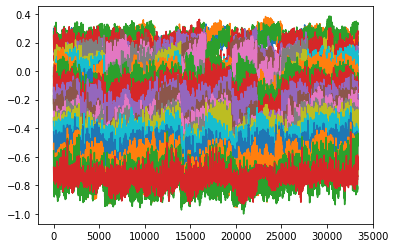

In [963]:
# Flatten data

# Create data accessor for flat arrays
flat_data_idx = lambda wav_idx, win_idx: flat_2d_array_idx(
    wav_idx, win_idx, n_files, n_windows)

# Create flat mel spectra 
# flat_mels: (33408, 128)
flat_mels_prenorm = np.array([ all_mels[wav_file_idx][:, window_idx] 
                               for wav_file_idx in range(n_files) 
                               for window_idx in range(n_windows) ])
print(flat_mels_prenorm)
# Normalize each mel spectrum to [0, 1]
# flat_mels, mels_scales = normalize_rows(flat_mels_prenorm, NormMode.NONNEG_TO_ZERO_ONE)

# Globally normalize to [-1, 1]
flat_mels_prenorm_log = np.log(flat_mels_prenorm)

flat_mels_scale = np.amax(np.absolute(flat_mels_prenorm_log))
flat_mels = flat_mels_prenorm_log / flat_mels_scale

plt.figure()
plt.plot(flat_mels)

print(flat_mels.shape)


In [964]:
# Create mfccs features
# flat_mfcc: (33408, 20)
flat_mfcc_prenorm = np.array([ all_mfcc[wav_file_idx][:, window_idx]
                               for wav_file_idx in range(n_files)
                               for window_idx in range(n_windows) ])
# Normalize each mfcc (i.e. rows of the all_mfcc array) to [0,1] - USE FOR THE VAE (TimbreVAE)
# flat_mfcc, mfcc_scales = normalize_rows(flat_mfcc_prenorm, NormMode.REAL_TO_ZERO_ONE)

# Globally normalize to [0, 1]
# log(-n) is nan, so we put things on a log scale from absolute values, and
# mutliply the sign back.
signs = np.sign(flat_mfcc_prenorm)
data_logged = signs * np.log(np.abs(flat_mfcc_prenorm))
max_mfcc = np.max(np.abs(np.array([ np.max(data_logged), np.min(data_logged) ])))
data_negtopos = data_logged / max_mfcc
# data_mfcc = normalize_rows(data_negtopos, NormMode.NEG_ONE_ONE_TO_ZERO_ONE)

flat_mfcc = torch.Tensor(data_negtopos)

print(flat_mfcc.shape)

# # To restore:
# restored_data = signs * np.e ** np.abs(
#     denormalize_rows(data_mfcc, DenormMode.ZERO_ONE_TO_NEG_ONE_ONE) * max_mfcc)
# # Visualize MFCCs
# plt.figure()
# plt.plot(flat_mfcc_prenorm[0])
# plt.figure()
# plt.plot(data_mfcc[0])
# plt.figure()
# plt.plot(restored_data[0])
# # Numeric verification
# print(flat_mfcc_prenorm[0])
# print(data_mfcc[0])
# print(restored_data[0])


torch.Size([33408, 24])


## Pre-Training

### Data-Label Structuring
This puts together the actual data-label pairs to be fed into the ANN.

`data` is generated from timbre features on mfcc and mel spectrums. `labels` are abs(fft) spectrograms. At this stage, pre-training, we simply want to make the NN learn to output fourier spectra.

Note that mel_spectra/mfcc of abs(fft) are equivalent to those of fft itself.

(576, 24, 58)
(576, 513, 58)
data shape =  (33408, 513)
label shape =  (33408, 513)


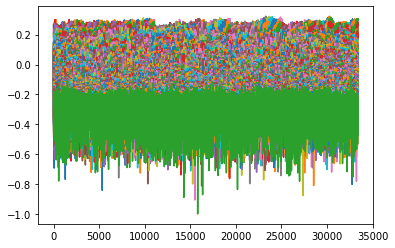

In [965]:
n_files, n_mfcc_dummy, n_windows = all_mfcc.shape
print(all_mfcc.shape)

# Create labels
# spectrograms: (576, 513, 58) (n_wavs, n_freq_bins, n_windows)
all_abs_spectrograms = np.abs(all_spectrograms)

print(all_abs_spectrograms.shape)

# data:   (33408, 168) (n_wavs * n_windows, n_mfcc + n_mels)
# labels: (33408, 513) (n_wavs * n_windows, n_fft / 2 + 1)
# data = np.concatenate((flat_mfcc, flat_mels), axis=1)

data_prenorm = np.array([ all_abs_spectrograms[wav_file_idx][:, window_idx]
                            for wav_file_idx in range(n_files)
                            for window_idx in range(n_windows) ])
data_prenorm_log = np.log(data_prenorm)
data_scales = np.amax(np.absolute(data_prenorm_log))
data  = data_prenorm_log / data_scales

print("data shape = ", data.shape)
plt.figure()
plt.plot(data)

labels_prenorm = np.array([ all_abs_spectrograms[wav_file_idx][:, window_idx]
                            for wav_file_idx in range(n_files)
                            for window_idx in range(n_windows) ])
print("label shape = ", labels_prenorm.shape)


Normalize `labels_prenorm` to range [-1,1]

In [966]:
# plt.figure()
# plt.plot(data)

# labels, label_scales = normalize_rows(labels_prenorm, NormMode.NONNEG_TO_ZERO_ONE)
# plt.figure()
# plt.plot(labels_prenorm)

labels_prenorm_log = np.log(labels_prenorm)
label_scales = np.amax(np.absolute(labels_prenorm_log))
labels  = labels_prenorm_log / label_scales

# plt.figure()
# plt.plot(labels)

print(data.shape, labels.shape)

(33408, 513) (33408, 513)


Split Data into `train` and `test`, and convert to Torch tensors of the correct types. Run **only one of these cells.**


In [967]:
# X_train, Y_train: (22272, 168) (22272, 513) 
# X_val, Y_val:     (11136, 168) (11136, 513)
X_train = []; X_val = []; Y_train = []; Y_val = []
for vow_idx in range(n_vowels):
    for pit_idx in range(n_pitches):
        # Choose the person for this pitch/vowel to be used as test data
        test_pid = int(np.random.rand() * 3)
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
            if (pid_idx != test_pid):
                for win_idx in range(n_windows):
                    X_train.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_train.append(labels[flat_data_idx(wav_idx, win_idx)])
            else:
                for win_idx in range(n_windows):
                    X_val.append(data[flat_data_idx(wav_idx, win_idx)])
                    Y_val.append(labels[flat_data_idx(wav_idx, win_idx)])  
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
# Default tensor is float
X_train = X_train.float(); X_val = X_val.float()
Y_train = Y_train.float(); Y_val = Y_val.float()

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

torch.Size([22272, 513]) torch.Size([22272, 513]) torch.Size([11136, 513]) torch.Size([11136, 513])


## Training Procedure

In [968]:
n_input = 513; n_hid2 = 386; n_hid = 260; n_ffts = 513; n_mels=65;
lr = 0.2; n_epochs = 500; batch_size=22272//8;

# Training model 
model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_hid2=n_hid2, n_ffts=n_ffts, n_mels=n_mels)

loss_fn = nn.MSELoss()

[-0.01520548  0.01033643 -0.03747021  0.00941396 -0.0381178   0.0231502
  0.03876814 -0.01328972 -0.01447222 -0.00488462 -0.00964938  0.03366189
  0.04625624  0.02164498 -0.0504876  -0.03265463  0.05452177  0.00915247
 -0.04493443 -0.02053429 -0.01817534  0.01329866 -0.07107152 -0.03120475
 -0.01744247 -0.00691947  0.08435237  0.0284716  -0.03823952  0.05808562
 -0.037328   -0.04044481 -0.00774843  0.01071358 -0.01300172  0.0092739
 -0.0087984  -0.01680291  0.02995722  0.01888047 -0.05421012  0.03431937
 -0.05322774 -0.0238591  -0.0507623   0.04419054 -0.03656823 -0.09753751
  0.03655533 -0.04835637 -0.00951103 -0.01037883  0.00026371 -0.0724
  0.00219964 -0.01214797 -0.03926872 -0.00450885 -0.03387332 -0.02888454
 -0.02244358 -0.07552756  0.04006343 -0.01409805  0.02133733 -0.0415767
  0.03452281  0.05531149 -0.00629957 -0.01232225  0.01407215 -0.02336721
  0.00309678  0.05784005  0.03929292 -0.00805904 -0.01067959  0.03589122
 -0.01945898  0.00474366 -0.02469215  0.02031441 -0.029889

[-1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.
  1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.  1.
 -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.
  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1.
  1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1

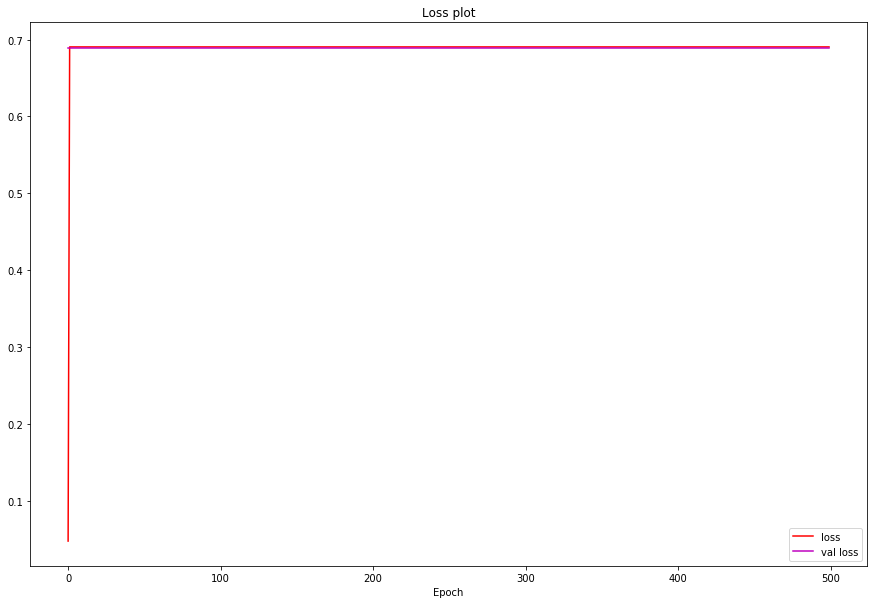

Training Loss before/after: 0.047768011689186096, 0.6905108094215393
Validation Loss before/after: 0.688831627368927, 0.688831627368927
Final loss: 0.6905108094215393
Time taken: 397.7751648426056


In [969]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Move the network to GPU (if possible)
model.to(device)

# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
train_loss, val_loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                        loss_fn, batch_size=batch_size, epochs=n_epochs, print_graph=True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(train_loss, toc - tic))

Saving the model

In [970]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
model_path = os.path.join("model_data", "TimbreFNNDecoder_fft-fft_{}_{}_{}_{}_{}_{}_{}_{}.pt"
                          .format(lr, n_epochs, n_mfcc, n_mels, n_hid, n_hid2, n_ffts, train_loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Model's state_dict:
fc1.weight 	 torch.Size([260, 513])
fc1.bias 	 torch.Size([260])
fc2.weight 	 torch.Size([386, 260])
fc2.bias 	 torch.Size([386])
fc3.weight 	 torch.Size([513, 386])
fc3.bias 	 torch.Size([513])
net.0.weight 	 torch.Size([260, 513])
net.0.bias 	 torch.Size([260])
net.2.weight 	 torch.Size([386, 260])
net.2.bias 	 torch.Size([386])
net.4.weight 	 torch.Size([513, 386])
net.4.bias 	 torch.Size([513])
Model saved at model_data/TimbreFNNDecoder_fft-fft_0.2_500_40_65_260_386_513_0.6905108094215393.pt


Loading the saved model, and using the model for prediction example

torch.Size([33408, 513])
torch.Size([33408, 513])


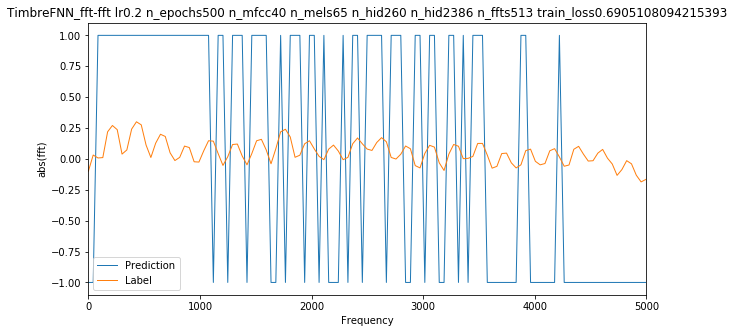

In [971]:
model = TimbreFNN(n_input=n_input, n_hid=n_hid, n_hid2=n_hid2, n_ffts=n_ffts)
model.load_state_dict(torch.load(model_path))
model.eval()
# model.to(device)


data_tensor, label_tensor = map(torch.tensor, (data, labels))
data_tensor = data_tensor.float(); label_tensor = label_tensor.float(); 
# data_tensor = data_tensor.to(device); label_tensor = label_tensor.to(device)

print(data_tensor.shape)
print(label_tensor.shape)

predictions = model(data_tensor).detach().numpy()


x_axis = librosa.core.fft_frequencies(sample_rate, 1024)
plt.figure(figsize=(10, 5))
plt.plot(x_axis, predictions[30000], label='Prediction', linewidth=1)
plt.plot(x_axis, label_tensor[30000], label='Label', linewidth=1)
plt.xlim(0, 5000)
plt.xlabel('Frequency')
plt.ylabel('abs(fft)')
plt.legend(loc='best')
title = "lr" + str(lr) + " n_epochs" + str(n_epochs) + " n_mfcc" + str(n_mfcc) + " n_mels" + str(n_mels) + " n_hid" + str(n_hid) + " n_hid2" + str(n_hid2) + " n_ffts" + str(n_ffts) + " train_loss" + str(train_loss)
plt.title("TimbreFNN_fft-fft " + title)

plt.savefig(model_path + '.png')